# PDF-Based Probability Smoothing with Naive and Backpropagation Models

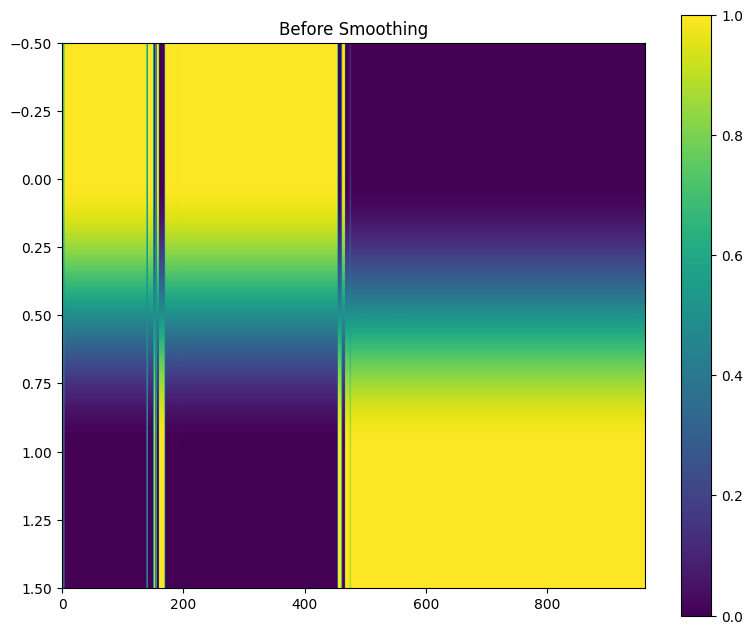

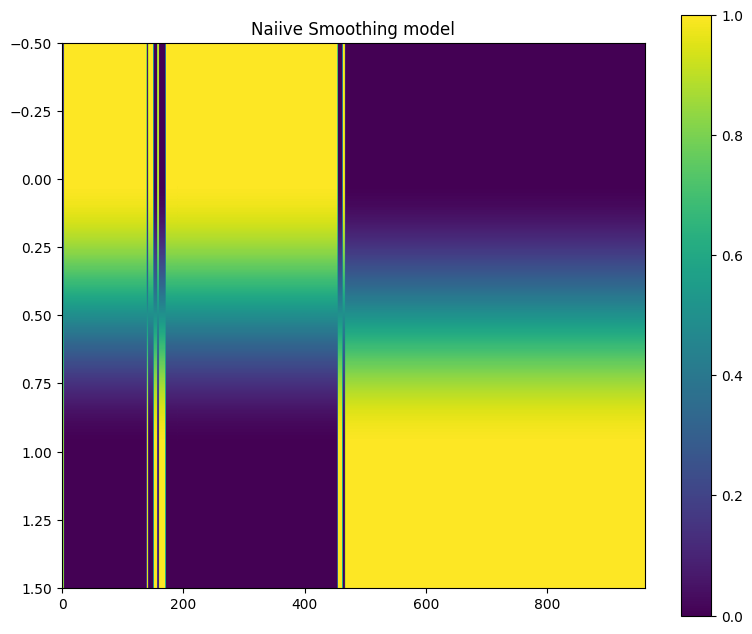

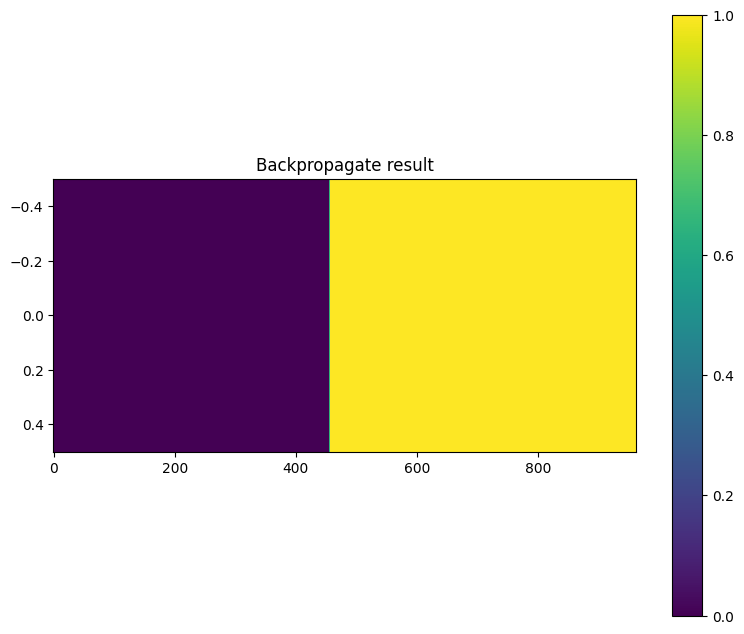

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio
from scipy.stats import multivariate_normal


def multivariate_normal_pdf(x, mX, Sigma):
    n = len(x)
    mu1 = mX[:, 0]
    mu2 = mX[:, 1]
    cov1 = Sigma[:, :, 0]
    cov2 = Sigma[:, :, 1]
    det1 = np.linalg.det(cov1)
    inv1 = np.linalg.inv(cov1)
    det2 = np.linalg.det(cov2)
    inv2 = np.linalg.inv(cov2)

    coeff1 = 1.0 / (np.power((2 * np.pi), n / 2) * np.power(det1, 0.5))
    exponent1 = -0.5 * (x - mu1).T @ inv1 @ (x - mu1)
    p1 = coeff1 * np.exp(exponent1)

    coeff2 = 1.0 / (np.power((2 * np.pi), n / 2) * np.power(det2, 0.5))
    exponent2 = -0.5 * (x - mu2).T @ inv2 @ (x - mu2)
    p2 = coeff2 * np.exp(exponent2)

    return p1, p2


if __name__ == '__main__':
    audio, sr = librosa.load('/content/Piano_Clap.wav', sr=None)
    file1 = scipy.io.loadmat('/content/mfcc.mat')
    file2 = scipy.io.loadmat('/content/MuSigma.mat')
    X = file1["X"]
    mX = file2["mX"]
    Sigma = file2["Sigma"]

    P = np.zeros((2, 962))
    P_hat = np.zeros((2, 962))
    P_vet = np.zeros((2, 962))
    B = np.zeros((2, 962))

    for i in range(len(X[0])):
        x = X[:, i]
        pdf1, pdf2 = multivariate_normal_pdf(x, mX, Sigma)
        P[:, i] = pdf1, pdf2
        P[:, i] = P[:, i]/np.sum(P[:, i])


    P_bar = P

    plt.figure(figsize=(9.4, 7.8))
    plt.imshow(P_bar, aspect=450)
    plt.title("Before Smoothing")
    plt.colorbar()
    plt.show()

    T = np.array([[0.9,  0.1], [0, 1]])
    P_hat[:, 0] = P_bar[:, 0]

    for t in range(len(X[0])-1):
        b = np.argmax(P_bar[:, t])
        mul1 = T[b, :]
        P_hat[:, t + 1] = np.multiply(mul1, P_bar[:, t + 1])
        P_hat[:, t + 1] = P_hat[:, t + 1] / np.sum(P_hat[:, t + 1])

    plt.figure(figsize=(9.4, 7.8))
    plt.imshow(P_hat, aspect=450)
    plt.title("Naiive Smoothing model")
    plt.colorbar()
    plt.show()

    P_vet[:, 0] = P_bar[:, 0]
    for t in range(len(X[0])-1):
        mul01 = T[:, 0]
        mul2 = P_vet[:, t]
        mul11 = T[:, 1]
        temp0 = mul01 * mul2
        temp1 = mul11 * mul2
        b0 = np.argmax(temp0)
        b1 = np.argmax(temp1)
        B[0, t + 1] = b0
        B[1, t + 1] = b1

        P_vet[0, t + 1] = T[b0, 0] * P_vet[b0, t] * P_bar[0, t + 1]
        P_vet[1, t + 1] = T[b1, 1] * P_vet[b1, t] * P_bar[1, t + 1]

        help_p = T[b0, 0] * P_vet[b0, t]
        help_2 = help_p * P_bar[0, t + 1]

        P_vet[:, t+1] = P_vet[:, t+1]/np.sum(P_vet[:, t+1])

    # B = B[:, 1:961]
    s = np.zeros((1, 962))
    s[0, 961] = np.argmax(P_vet[:, 961])

    for t in range(961, 0, -1):
        row = int(s[0, t])
        s[0, t-1] = B[row, t-1]

    plt.figure(figsize=(9.4, 7.8))
    plt.imshow(s, aspect=450)
    plt.title("Backpropagate result")
    plt.colorbar()
    plt.show()
